<a href="https://colab.research.google.com/github/cristina-ramos/class_NLP/blob/main/Assignments/text_classification_feedforward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import os
import io
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

> Importing IMDB dataset following tensorflow's guide

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 10s 0us/step


In [ ]:
print(os.listdir(dataset_dir))
train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(train_dir))

['imdb.vocab', 'imdbEr.txt', 'README', 'train', 'test']
['unsup', 'labeledBow.feat', 'urls_unsup.txt', 'unsupBow.feat', 'urls_pos.txt', 'neg', 'pos', 'urls_neg.txt']


> Preparing dataset for binary classification: removing unnecessary folders and creating validation set

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
batch_size = 64
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


> Exploring the dataset:

In [ ]:
# for text_batch, label_batch in raw_train_ds.take(1):
#   for i in range(3):
#     print("Review", text_batch.numpy()[i])
#     print("Label", label_batch.numpy()[i])

In [ ]:
# print("Label 0 corresponds to", raw_train_ds.class_names[0])
# print("Label 1 corresponds to", raw_train_ds.class_names[1])

> Creating validation set:

In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


> Preprocessing the dataset:

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
# def vectorize_text(text, label):
#   text = tf.expand_dims(text, -1)
#   return vectorize_layer(text), label

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

> Configuring dataset and creating NN model:

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
embedding_dim = 20

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.5),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.8),
  layers.Dense(1),
  layers.Dense(1)])

model.summary()
#this is so cool

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 20)          200020    
_________________________________________________________________
dropout_50 (Dropout)         (None, None, 20)          0         
_________________________________________________________________
dropout_51 (Dropout)         (None, None, 20)          0         
_________________________________________________________________
global_average_pooling1d_19  (None, 20)                0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 21        
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

> Loss Function:

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

> Training the model:

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
313/313 [==============================] - 10s 33ms/step - loss: 0.6880 - binary_accuracy: 0.5803 - val_loss: 0.6773 - val_binary_accuracy: 0.7384
Epoch 2/10
313/313 [==============================] - 4s 14ms/step - loss: 0.6484 - binary_accuracy: 0.6995 - val_loss: 0.6095 - val_binary_accuracy: 0.7722
Epoch 3/10
313/313 [==============================] - 4s 14ms/step - loss: 0.5672 - binary_accuracy: 0.7677 - val_loss: 0.5169 - val_binary_accuracy: 0.8112
Epoch 4/10
313/313 [==============================] - 4s 14ms/step - loss: 0.4905 - binary_accuracy: 0.8069 - val_loss: 0.4433 - val_binary_accuracy: 0.8352
Epoch 5/10
313/313 [==============================] - 6s 18ms/step - loss: 0.4375 - binary_accuracy: 0.8256 - val_loss: 0.3951 - val_binary_accuracy: 0.8520
Epoch 6/10
313/313 [==============================] - 7s 21ms/step - loss: 0.4046 - binary_accuracy: 0.8394 - val_loss: 0.3648 - val_binary_accuracy: 0.8608
Epoch 7/10
313/313 [==============================] - 4s 

> Evaluating model and creating plot:

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

391/391 [==============================] - 9s 23ms/step - loss: 0.3253 - binary_accuracy: 0.8694
Loss:  0.3253061771392822
Accuracy:  0.8694400191307068


In [ ]:
history_dict = history.history
# history_dict.keys()

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

> Training and Validation Loss:

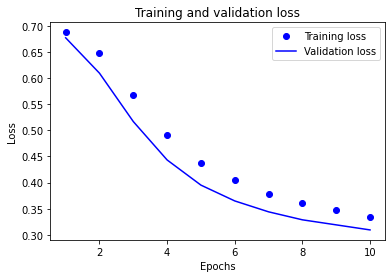

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

> Training and Validation Accuracy:

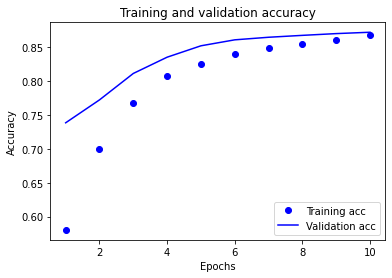

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

> Word Embeddings:

In [ ]:
batch_size = 1024
seed = 123
train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2, 
    subset='training', seed=seed)
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2, 
    subset='validation', seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
embedding_layer = tf.keras.layers.Embedding(1000, 5)

In [ ]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

In [ ]:
vocab_size = 10000
sequence_length = 100

In [ ]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [ ]:
embedding_dim=16

model = tf.keras.Sequential([
  vectorize_layer,
  layers.Embedding(vocab_size, embedding_dim, name="embedding"),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=15,
    callbacks=[tensorboard_callback])

In [ ]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [ ]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if  index == 0: continue # skip 0, it's padding.
  vec = weights[index] 
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception as e:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

> SKlearn Log Regression:

In [ ]:
from sklearn import datasets, linear_model, metrics
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [ ]:
#using the same split dataset function as I did with keras:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
vect = TfidfVectorizer()
X = vect.fit_transform(train_ds)

AttributeError: ignored